Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 当ノートブックのワークフロー  
速度定数を時間の関数として表現する場合の事例。  
1. 未知の速度定数を含む、csvに書き込んだ反応式を読み込む。  
2. 化学種の濃度の経時変化の実験データを読み込む。実験データには欠損を含んでもよい。  
2. RxnIVPsolv("sample_data.csv")でインスタンス化し、化学種ごとの微分型の反応速度式を作成する。速度定数が未知の素反応にはシンボリックな変数が割り振られる。  
3. 作成した微分方程式を、数値解析可能な形式にする  
4.  scipy.optimize.minimizeを使い、化学種ごとの濃度の経時変化が、実験値と近づくように、未知の速度定数を求める： get_ode_system()で必要なオブジェクトを取得。  
5. 経時変化を図示する： matplotlibで結果をプロット  

もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できる。  


## 引用文献  
6) Kinetics of Polyesterification: A Study of the Effects of Molecular Weight and Viscosity on Reaction Rate
Paul J. Flory, Journal of the American Chemical Society 1939 61 (12), 3334-3340, DOI: 10.1021/ja01267a030
https://doi.org/10.1021/ja01267a030  

Table Iのデータに以下の処理を施した。内容はref6.xlsxを参照のこと。  
- diethylene glycol (DEG: MW 106.12), adipic acid (AdA: MW 146.14)とした。CRUのMWは 106.12 + 146.12 - 18.02 x 2 = 216.22とした。  
- 初期濃度t = 0は、モノマーであるDEGとAdAが、1,000 g 中に等物質量ずつ含まれているとした。ともに3.964 molずつで、 DEG (420.7 g)、AdA (579.3 g) になる。  
- polyesterのDPnからMnを算出した。DPn=0の場合を除き、Mn = DPn x 216.22 + 18.02 とした。  
- 触媒の重量は無視できるとした。  
- 各反応時間でのモノマー残量は表中のρ（転嫁率に相当）から算出した。  
- 発生した水は速やかに系から除去されるとし、その重量をρから算出した。t=0での総重量 1,000 gから、発生した水の重量を減じ、各時間での総重量を求めた。  
- DEG, AdA以外はすべてpolyesterと考えてその重量を算出し、各時間でのMnから主査の物質量とした。これを各時間の総重量で割り、polyesterの濃度を算出した。  
- 各時間での、各化学種の物質量を、その時点での総重量で除し、濃度とした。  

解析は、Mnの成長速度を見込むことを目標にした。成長の速度定数kpは、モノマー同士の速度定数kmのと時間の関数として表現でき、ある時間でのkpは  
kp = km x exp(-a*t)  
で表されると仮定した。重合の初期速度はモノマー同士の反応と等しい、という考え方である。  
よって、フィッティングでは、kmとaを求めることとなる。  
この際、以下の対応をしている。  
- 現行versionのrxnfitでは、出発物のみの半反応は扱うことができるが、生成物のみの半反応を扱うことができない。このためダミー中間体として "olg" （オリゴマー）を設定し、その濃度はt=0で0、他は全て未知（空欄）とした。  
- Mnは1e3、AdAやDEGの濃度は1e-3  の桁でレンジが異なりすぎるため、Mnを1e-6倍してフィッティングした。  



## 反応式, 速度定数の定義を記載したcsvファイルを指定する  

In [2]:
file_path_rxn = './sample_data/ref6/sample_rxn_ref6.csv'  # CSVファイルのパスを指定
file_path_k = './sample_data/ref6/sample_k_ref6.csv'

## 反応速度式をscipy.integrate.solve_ivpで処理できる連立微分方程式にする  

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sympy import Symbol
from sympy.core.symbol import Symbol as SympySymbol
import inspect

from rxnfit.build_ode import RxnODEbuild, create_system_rhs
from rxnfit.solv_ode import SolverConfig, RxnODEsolver
from rxnfit.expdata_reader import expdata_read, get_y0_from_expdata
from rxnfit.expdata_fit_sci import ExpDataFitSci

# 反応速度式の作成

In [4]:
builded_rxnode = RxnODEbuild(
    file_path_rxn, 
    rate_const_overrides=file_path_k) # 時間の関数で表現される速度定数の定義場所を指定  

In [5]:
builded_rxnode.get_ode_info(debug_info=True)

number of species: 4
unique species: ['DEG', 'AdA', 'olg', 'Mn']
rate constant: {'km': km, 'kp': km*exp(-a*t)}

=== debug info ===
Successfully created function for DEG with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for AdA with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for olg with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for Mn with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
order of args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
system of ODE: {'DEG': '-km*DEG(t)*AdA(t)', 'AdA': '-km*DEG(t)*AdA(t)', 'olg': 'km*DEG(t)*AdA(t)-kp*olg(t)', 'Mn': 'kp*olg(t)'}


In [6]:
# 作成した微分方程式
builded_rxnode.get_ode_system()[0]

Successfully created function for DEG with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for AdA with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for olg with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for Mn with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']


[Eq(Derivative(DEG(t), t), -km*AdA(t)*DEG(t)),
 Eq(Derivative(AdA(t), t), -km*AdA(t)*DEG(t)),
 Eq(Derivative(olg(t), t), km*AdA(t)*DEG(t) - km*olg(t)*exp(-a*t)),
 Eq(Derivative(Mn(t), t), km*olg(t)*exp(-a*t))]

In [7]:
# 速度定数の確認
print(builded_rxnode.rate_consts_dict)

check_type = [v for v in builded_rxnode.rate_consts_dict.values()]
[type(e) for e in check_type]

{'km': km, 'kp': km*exp(-a*t)}


[sympy.core.symbol.Symbol, sympy.core.mul.Mul]

## 経時変化の実験データを読み込み　　
### データフレーム化  

In [8]:
file_path_data = './sample_data/ref6/sample_timecourse_ref6.csv' # データファイルのパス
df1 = pd.read_csv(file_path_data)

expdata_read([df1,])  # 複数データフレームのリストを渡すとまとめて読み込み可能

[([array([   0,    6,   12,   23,   37,   59,   88,  129,  170,  203,  235,
           270,  321,  397,  488,  596,  690,  793,  900, 1008, 1147, 1370,
          1606]),
   array([   0,    6,   12,   23,   37,   59,   88,  129,  170,  203,  235,
           270,  321,  397,  488,  596,  690,  793,  900, 1008, 1147, 1370,
          1606]),
   array([], dtype=int64),
   array([   0,    6,   12,   23,   37,   59,   88,  129,  170,  203,  235,
           270,  321,  397,  488,  596,  690,  793,  900, 1008, 1147, 1370,
          1606])],
  [array([0.00396416, 0.00345151, 0.00303863, 0.00257493, 0.00206539,
          0.00162451, 0.00130685, 0.0010418 , 0.00088474, 0.00077414,
          0.00069599, 0.00063306, 0.00056121, 0.0004921 , 0.00043458,
          0.00038832, 0.00035504, 0.00033101, 0.00030864, 0.00029597,
          0.00027442, 0.00025286, 0.00023508]),
   array([0.00396416, 0.00345151, 0.00303863, 0.00257493, 0.00206539,
          0.00162451, 0.00130685, 0.0010418 , 0.00088474, 0.0007

### フィッティング  
ExpDataFitSci でシンボリックな速度定数をフィッティング。  


In [9]:
# ExpDataFitSci でフィッティング（t_range, df_list 必須）
t_range = (float(df1.iloc[:, 0].min()), float(df1.iloc[:, 0].max()))
fit_sci = ExpDataFitSci(builded_rxnode, [df1], t_range)


In [10]:
# p0 に入力する変数の順番を表示（run_fit の前に確認用）
keys = builded_rxnode.get_symbolic_rate_const_keys()
print("p0の変数順 (symbolic_rate_consts):", keys)
print("p0の要素数:", len(keys))

p0の変数順 (symbolic_rate_consts): ['a', 'km']
p0の要素数: 2


In [11]:
# 未知の速度定数の初期値
result, param_info = fit_sci.run_fit(p0=[5e-2,2]) 

Successfully created function for DEG with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for AdA with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for olg with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for Mn with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
最適化成功: True
最適化された速度定数:
  a = 1e-10
  km = 2.00317
残差二乗和: 3.12456e-05


In [12]:
# フィッティング結果で builded_rxnode を更新し、SolverConfig を取得
# fit_sci.get_fitted_rate_const_dict() と get_solver_config_args() を使用
builded_rxnode.rate_consts_dict.update(fit_sci.get_fitted_rate_const_dict())
config = SolverConfig(**fit_sci.get_solver_config_args())

## 数値積分を実行する  

In [13]:
# 最適化結果および与えたデータから、solve_ivp に渡す引数を作成
# 1. ODE システムと system_rhs を取得（builded_rxnode.rate_consts_dict は上記で更新済み）
ode_construct = builded_rxnode.get_ode_system()
(system_of_equations, sympy_symbol_dict, ode_system,
 function_names, rate_consts_dict) = ode_construct
system_rhs = create_system_rhs(ode_system, function_names)

# 2. 実験データの時間点を t_eval に使用（任意・省略可）
t_eval = np.array(df1.iloc[:, 0].values, dtype=float)

# 3. solve_ivp に渡す引数を構築（config を引き継ぎ、fun と t_eval を追加）
solve_ivp_kwargs = {
    'fun': system_rhs,
    **vars(config),
    't_eval': t_eval,
}

Successfully created function for DEG with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for AdA with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for olg with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']
Successfully created function for Mn with args: ['t', 'DEG', 'AdA', 'olg', 'Mn']


In [14]:
# 基本的な数値積分 -インスタンス化-
solved_rxnode = RxnODEsolver(builded_rxnode, config)

In [15]:
ode_construct, sol = solved_rxnode.solve_system()


=== Time-course plot ===


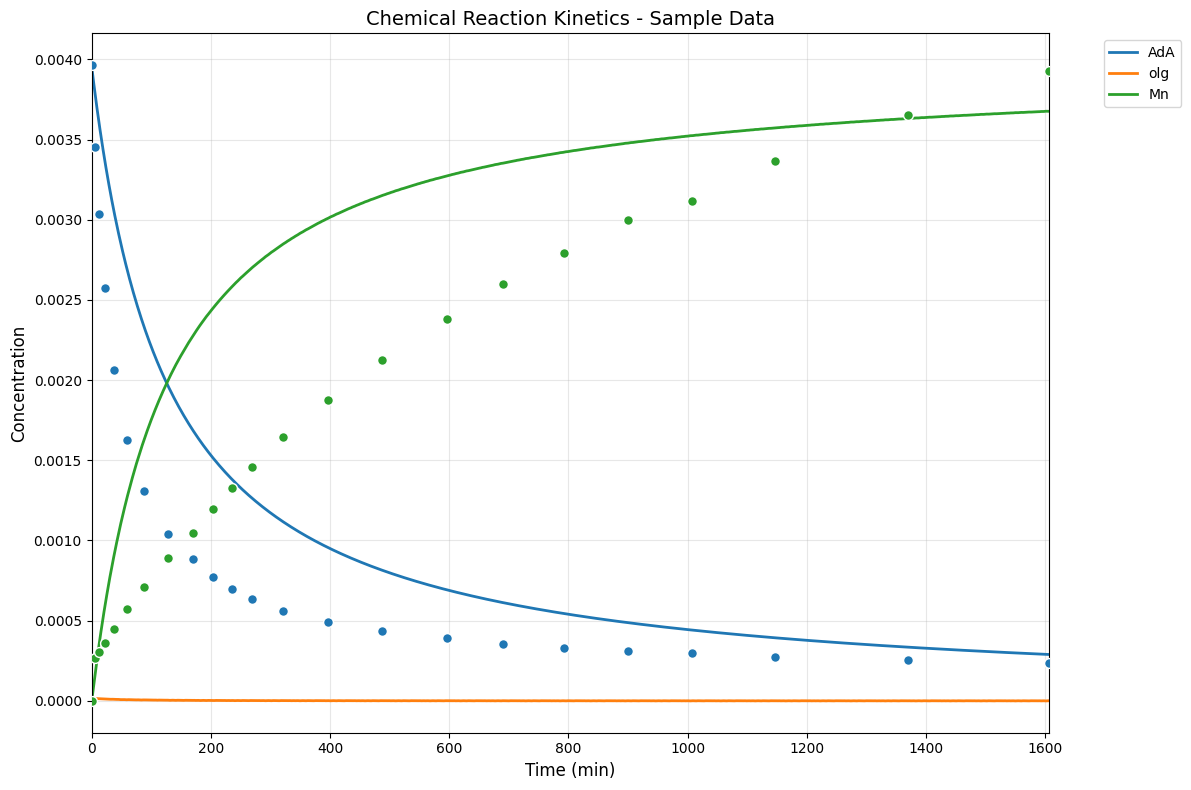


=== Concentration at the final time point ===
AdA: 0.000288
olg: -0.000000
Mn: 0.003676


In [16]:
# シミュレーション曲線に実験データ点を重ねる（線と点で色を揃える）
solved_rxnode.solution_plot(expdata_df=df1, species=['AdA', 'olg', 'Mn'])